In [11]:
"""
03_pairwise_association.ipynb

Purpose
-------
This notebook examines pairwise associations among process variables to complement
the results of the lasso-regularized logistic regression model. In particular, it
identifies variables that were not selected by lasso but are strongly associated
with selected features, and may therefore be relevant to manufacturing failures.

Approach
--------
Lasso logistic regression is first refit using the combined training and validation
data with the selected regularization parameter (C = 0.0003) to recover the final
set of selected features. Because lasso retains only one representative from groups
of correlated variables, pairwise Spearman correlations are then computed between
the selected features and all remaining non-selected features.

Only strong associations (|ρ| ≥ 0.6) are retained to keep the results interpretable
and practically useful. These associations are visualized using a filtered heatmap
and summarized in a grouped table that, for each selected feature, lists non-selected
features with strong monotonic similarity.

All association analyses are performed using the training and validation data only;
the test set is not used.

Inputs
------
- X_train.csv, y_train.csv  
- X_val.csv, y_val.csv  

Outputs
-------
- lasso_selected_features_C_0p0003.csv  
- pairwise_spearman_heatmap_strong.png  
- lasso_selected_plus_strong_spearman_grouped_rho_ge_0p6.csv  
"""

'\n03_pairwise_association.ipynb\n\nPurpose\n-------\nThis notebook examines pairwise associations among process variables to complement\nthe results of the lasso-regularized logistic regression model. In particular, it\nidentifies variables that were not selected by lasso but are strongly associated\nwith selected features, and may therefore be relevant to manufacturing failures.\n\nApproach\n--------\nLasso logistic regression is first refit using the combined training and validation\ndata with the selected regularization parameter (C = 0.0003) to recover the final\nset of selected features. Because lasso retains only one representative from groups\nof correlated variables, pairwise Spearman correlations are then computed between\nthe selected features and all remaining non-selected features.\n\nOnly strong associations (|ρ| ≥ 0.6) are retained to keep the results interpretable\nand practically useful. These associations are visualized using a filtered heatmap\nand summarized in a gr

### Get list of attributes used in logistic regression model c = .0003 from previous notebook
In this step, the attributes from the selected model from notebook 2 are obtained and exported to a csv. 

In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Settings
# -----------------------------
DATA_DIR = "../data/cleaned"
target_col = "outcome"

C_final = 3e-4          # = 0.0003
nonzero_threshold = 1e-5

out_dir = "../results/tables"
os.makedirs(out_dir, exist_ok=True)

# -----------------------------
# Load train + validation only
# -----------------------------
X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")[target_col].astype(int).values

X_val = pd.read_csv(f"{DATA_DIR}/X_val.csv")
y_val = pd.read_csv(f"{DATA_DIR}/y_val.csv")[target_col].astype(int).values

# Ensure labels are 0/1
y_train = (y_train == 1).astype(int)
y_val   = (y_val == 1).astype(int)

# Combine train + validation
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val])

# Sanity check
assert list(X_train.columns) == list(X_val.columns), "Train/val feature columns are misaligned"

# -----------------------------
# Fit lasso logistic model
# -----------------------------
final_model = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=C_final,
    class_weight="balanced",
    max_iter=5000,
    tol=1e-3,
    n_jobs=-1,
    random_state=42
)

final_model.fit(X_trainval, y_trainval)

# -----------------------------
# Extract selected attributes
# -----------------------------
coef = final_model.coef_.ravel()
feature_names = np.array(X_trainval.columns)

selected_mask = np.abs(coef) > nonzero_threshold

selected_df = (
    pd.DataFrame({
        "feature": feature_names[selected_mask],
        "abs_coefficient": np.abs(coef[selected_mask]),
        "sign": np.where(coef[selected_mask] > 0, "+", "-"),
    })
    .sort_values("abs_coefficient", ascending=False)
    .reset_index(drop=True)
)

# -----------------------------
# Save + display
# -----------------------------
csv_path = f"{out_dir}/lasso_selected_features_C_0p0003.csv"
selected_df.to_csv(csv_path, index=False)

print(f"Selected features: {len(selected_df)}")
print(f"Saved: {csv_path}")

selected_df

# List of selected attributes (set S)
selected_features = selected_df["feature"].tolist()

print(f"Number of selected features: {len(selected_features)}")
selected_features


Selected features: 29
Saved: ../results/tables/lasso_selected_features_C_0p0003.csv
Number of selected features: 29


['attribute_89',
 'attribute_469',
 'attribute_511',
 'attribute_512',
 'attribute_489',
 'attribute_3',
 'attribute_2',
 'attribute_419',
 'attribute_91',
 'attribute_487',
 'attribute_485',
 'attribute_522',
 'attribute_22',
 'attribute_161',
 'attribute_23',
 'attribute_486',
 'attribute_56',
 'attribute_205',
 'attribute_141',
 'attribute_4',
 'attribute_483',
 'attribute_490',
 'attribute_500',
 'attribute_501',
 'attribute_162',
 'attribute_434',
 'attribute_488',
 'attribute_24',
 'attribute_25']

## Pairwise Association
In this step, Spearman correlation is used to examine pairwise associations between the 29 features selected by the lasso-regularized logistic regression model and the remaining features in the combined training and validation data. The features selected by the model are useful for prediction, but lasso is known to retain only a single representative from groups of strongly correlated variables, suppressing other variables that may carry similar information.

Because the goal of this project is to identify process variables associated with manufacturing failures rather than to isolate a minimal predictive set, we explicitly account for this behavior. Let S denote the set of features selected by the lasso model, and R the set of remaining features. For each feature in S, we compute its Spearman correlation with all features in R and identify variables that are strongly associated but were not selected by the model.

A Spearman correlation threshold of |ρ| ≥ 0.6 is used to restrict attention to strong, near-redundant associations. Features meeting this criterion are added to the reported set as plausible alternatives that may have been excluded by lasso due to collinearity rather than lack of association with the outcome.

### Get training data and validation data into one df for pairwise association analysis

In [13]:
import pandas as pd

X_train = pd.read_csv("../data/cleaned/X_train.csv")
X_val   = pd.read_csv("../data/cleaned/X_val.csv")

y_train = pd.read_csv("../data/cleaned/y_train.csv")
y_val   = pd.read_csv("../data/cleaned/y_val.csv")

X_all = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_all = pd.concat([y_train, y_val], axis=0, ignore_index=True)

df_all = pd.concat([X_all, y_all], axis=1)


print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)
print("df_all shape:", df_all.shape)

assert df_all.shape[0] == X_all.shape[0]
assert df_all.shape[1] == X_all.shape[1] + y_all.shape[1]

X_all shape: (1253, 450)
y_all shape: (1253, 1)
df_all shape: (1253, 451)


### Run spearmans correlation 
In this step, spearmans correlation between each feature in set S (the set of features selected by the lasso model) and each feature in set R (the set of remaining features) will be computed. A heatmap of just the features with correlation >= .6 will be visualized. 

Total features: 450
Selected features (S): 29
Non-selected features (R): 421


C:\Users\Brooke Brocker\AppData\Local\Temp\ipykernel_2380\2998594930.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  corr_SR = X[S].corrwith(X[R_features], axis=0, method="spearman")


Strong-correlation heatmap shape: (19, 9)
Number of strong pairs (cells): 19


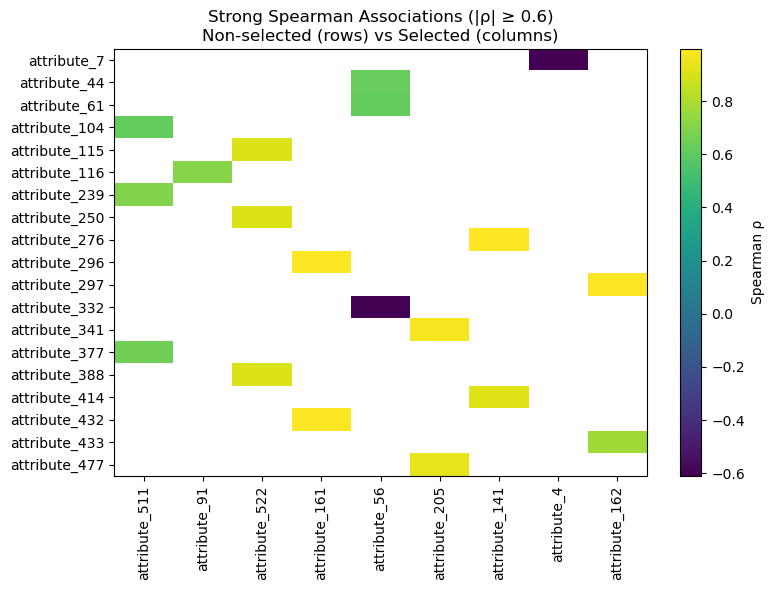

In [14]:
# set S is selected_features, get set R
# Features excluding outcome
all_features = [c for c in df_all.columns if c != "outcome"]

# Non-selected feature set R
R = [f for f in all_features if f not in selected_features]

print(f"Total features: {len(all_features)}")
print(f"Selected features (S): {len(selected_features)}")
print(f"Non-selected features (R): {len(R)}")

# create heatmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Settings
# -----------------------------
threshold = 0.6

# Use only numeric feature columns (exclude outcome)
X = df_all.drop(columns=["outcome"])

S = selected_features
R_features = R

# -----------------------------
# Compute Spearman correlations: S vs R
# -----------------------------
# Spearman = Pearson correlation on ranks, which pandas handles via method="spearman"
corr_SR = X[S].corrwith(X[R_features], axis=0, method="spearman")
# The line above won't do what we want because corrwith aligns columns.
# So compute full corr and then slice properly:

corr_all = X[S + R_features].corr(method="spearman")

# Extract the S (columns) vs R (rows) block
corr_block = corr_all.loc[R_features, S]

# Filter to strong associations only
mask_strong = corr_block.abs() >= threshold

# Keep only rows/cols that have at least one strong association
rows_keep = mask_strong.any(axis=1)
cols_keep = mask_strong.any(axis=0)

corr_strong = corr_block.loc[rows_keep, cols_keep]

# Replace weak cells with NaN so the heatmap is sparse/clean
corr_strong = corr_strong.where(corr_strong.abs() >= threshold)

print("Strong-correlation heatmap shape:", corr_strong.shape)
print("Number of strong pairs (cells):", int(np.sum(~corr_strong.isna().values)))

# -----------------------------
# Plot heatmap
# -----------------------------
plt.figure(figsize=(max(8, 0.4 * corr_strong.shape[1]), max(6, 0.25 * corr_strong.shape[0])))

plt.imshow(corr_strong.values, aspect="auto", interpolation="nearest")
plt.colorbar(label="Spearman ρ")

# Save figure
import os
os.makedirs("../results/figures", exist_ok=True)
plt.savefig("../results/figures/pairwise_spearman_heatmap_strong.png", dpi=300, bbox_inches="tight")

plt.xticks(ticks=np.arange(corr_strong.shape[1]), labels=corr_strong.columns, rotation=90)
plt.yticks(ticks=np.arange(corr_strong.shape[0]), labels=corr_strong.index)

plt.title(f"Strong Spearman Associations (|ρ| ≥ {threshold})\nNon-selected (rows) vs Selected (columns)")
plt.tight_layout()
plt.show()

### generate final csv that shows the above heatmap in table form

In [15]:
import os
import numpy as np
import pandas as pd

# -----------------------------
# Output directory
# -----------------------------
table_dir = "../results/tables"
os.makedirs(table_dir, exist_ok=True)

# -----------------------------
# Build grouped table
# -----------------------------
# Convert sparse matrix to long format first (drops NaNs automatically)
pairs_df = (
    corr_strong
    .stack()
    .reset_index()
)
pairs_df.columns = ["correlated_feature", "selected_feature", "spearman_rho"]

pairs_df["abs_rho"] = pairs_df["spearman_rho"].abs()
pairs_df["direction"] = np.where(pairs_df["spearman_rho"] > 0, "+", "-")

# Group by selected feature
grouped_df = (
    pairs_df
    .groupby("selected_feature", as_index=False)
    .agg(
        num_correlated_variables=("correlated_feature", "count"),
        strongly_correlated_features=("correlated_feature", lambda s: "; ".join(s.tolist())),
        spearman_rhos_with_selected=("spearman_rho", lambda s: "; ".join([f"{v:.3f}" for v in s.tolist()])),
        directions=("direction", lambda s: "; ".join(s.tolist()))
    )
    .sort_values("num_correlated_variables", ascending=False)
    .reset_index(drop=True)
)

# -----------------------------
# Optional: add lasso info (recommended)
# -----------------------------
# selected_df should have columns: feature, sign, abs_coefficient
if "selected_df" in globals():
    lasso_info = selected_df.rename(columns={
        "feature": "selected_feature",
        "sign": "selected_sign_in_model",
        "abs_coefficient": "selected_abs_coef"
    })[["selected_feature", "selected_sign_in_model", "selected_abs_coef"]]

    grouped_df = grouped_df.merge(lasso_info, on="selected_feature", how="left")

# -----------------------------
# Save CSV
# -----------------------------
csv_path = (
    f"{table_dir}/lasso_selected_plus_strong_spearman_grouped_"
    f"rho_ge_{str(threshold).replace('.', 'p')}.csv"
)
grouped_df.to_csv(csv_path, index=False)

print(f"Saved grouped CSV: {csv_path}")
print("Rows (selected features with ≥1 strong partner):", len(grouped_df))

grouped_df.head(10)


Saved grouped CSV: ../results/tables/lasso_selected_plus_strong_spearman_grouped_rho_ge_0p6.csv
Rows (selected features with ≥1 strong partner): 9


,selected_feature,num_correlated_variables,strongly_correlated_features,spearman_rhos_with_selected,directions,selected_sign_in_model,selected_abs_coef
0,attribute_522,3,attribute_115; attribute_250; attribute_388,0.914; 0.914; 0.914,+; +; +,+,0.000334
1,attribute_511,3,attribute_104; attribute_239; attribute_377,0.620; 0.694; 0.651,+; +; +,+,0.000825
2,attribute_56,3,attribute_44; attribute_61; attribute_332,0.624; 0.615; -0.602,+; +; -,+,0.000219
3,attribute_141,2,attribute_276; attribute_414,0.992; 0.921,+; +,-,0.000171
4,attribute_161,2,attribute_296; attribute_432,0.993; 0.991,+; +,+,0.000234
5,attribute_162,2,attribute_297; attribute_433,0.997; 0.767,+; +,-,0.000039
6,attribute_205,2,attribute_341; attribute_477,0.978; 0.935,+; +,-,0.000183
7,attribute_4,1,attribute_7,-0.609,-,-,0.000145
8,attribute_91,1,attribute_116,0.703,+,-,0.000437
